<a href="https://colab.research.google.com/github/AnirudhSinghBhadauria/pyspark/blob/main/crypto_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql.types import *
from pyspark import StorageLevel
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql.window import Window

In [37]:
spark = SparkSession.builder.appName('crypto-test').getOrCreate()

In [38]:
crypto_df = (
    spark.read.format("csv")
    .option("mode", "FAILFAST")
    .option("inferSchema", "true")
    .option("skipRows", 0)
    .option("header", "true")
    .load("/content/crypto_tradinds.csv")
)

In [ ]:
crypto_df.persist(StorageLevel.MEMORY_ONLY)

In [ ]:
crypto_df.filter(
    col("ticker") == 'ETH'
).show()

#### **Rolling Averages** for any crypto currency!

In [84]:
def rolling_average(currency, days):
  window = (Window.orderBy("trade_date").rowsBetween(-(days), 0))

  rolling_average_currency = (
      crypto_df
      .filter(
          col("ticker") == currency
      )
      .withColumn(
          "rolling_average",
          round(avg("price_usd").over(window), 3)
      )
  )

  y_value = [ravg.rolling_average for ravg in rolling_average_currency.select("rolling_average").collect()]
  x_value = [tdate.trade_date for tdate in rolling_average_currency.select("trade_date").collect()]

  plt.plot(x_value, y_value)
  plt.show()

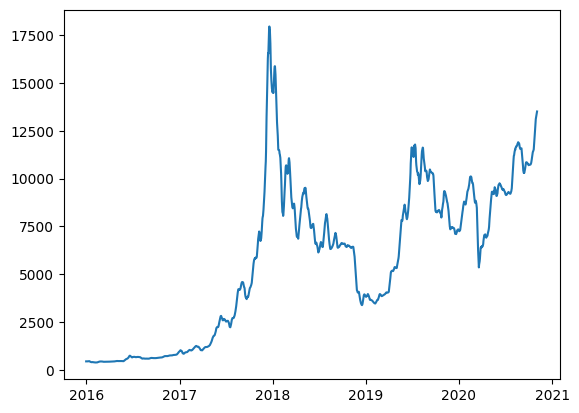

In [85]:
rolling_average("BTC", 7)

In [ ]:
(
  crypto_df
  .select(["ticker", "crypto_name"])
  .distinct()
  .sample(fraction = 0.5)
  .show(n = crypto_df.count(), truncate = False)
)